# Module Dependency

In [1]:
%matplotlib inline

import numpy as np
import skimage as ski
from skimage import exposure, io
from skimage.morphology import disk, square
from skimage.filters import rank, median, gaussian
from skimage.color import rgb2hsv, hsv2rgb, rgb2gray, gray2rgb
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (20.0, 16.0)

# Read Image

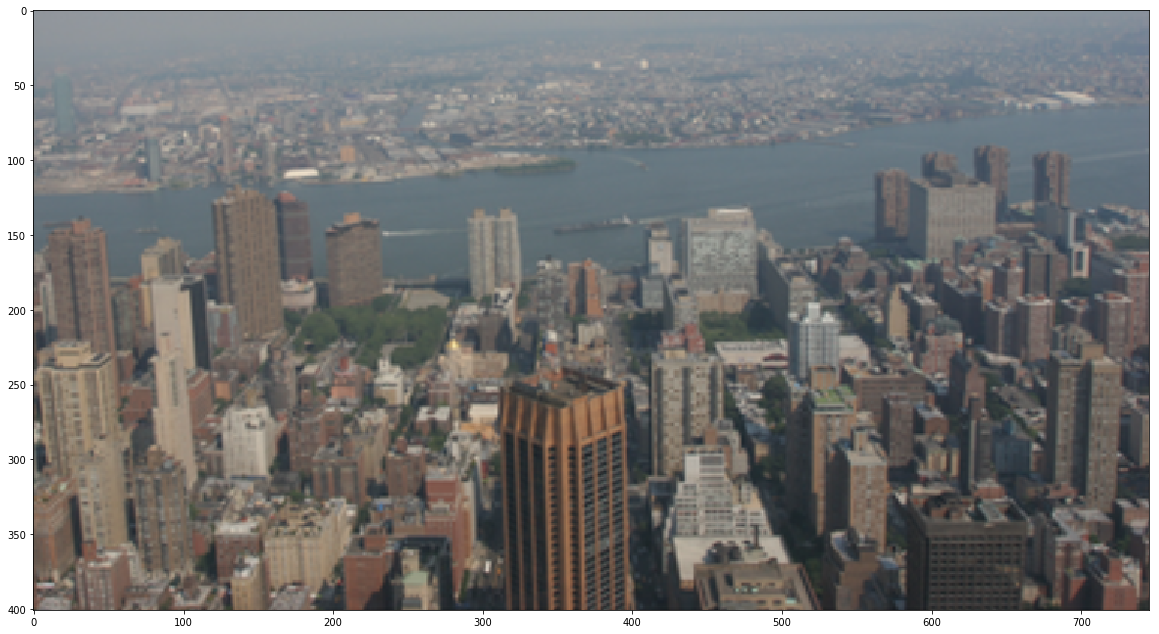

In [2]:
image = io.imread('./data/input4.bmp')
plt.imshow(image)

# Dark Channel Prior
I use class from [here](https://github.com/meijieru/dehaze).

I modify some code in *dark_channel* function to return dark channel after gaussian filter.

In [3]:
class DarkPriorChannelDehaze(object):
    """Dehaze using dark prior channel method from Kaiming He etc.
    Reference:
        [Single Image Haze Removal using Dark Channel Prior] \
                (http://kaiminghe.com/publications/cvpr09.pdf)
        [Guided Image Filtering] \
                (http://kaiminghe.com/publications/pami12guidedfilter.pdf)
    Args:
        wsize (int, optional): size of window for dark channel
        radius (int, optional): size of window for guided filter
        t_min (float, optional): minimum value of transmission
        ratio (float, optional): ratio of pixels used to estimate
            the atmosphere, refer to paper for details
        omega (float, optional): percantage of haze to be removed
        refine (bool, optional): whether to refine origin transmission
            estimation using guided filter
    """

    def __init__(self,
                 wsize=12,
                 radius=7,
                 t_min=0.1,
                 ratio=0.001,
                 omega=0.95,
                 refine=False):
        self.wsize = wsize
        self.radius = radius
        self.t_min = t_min
        self.ratio = ratio
        self.omega = omega
        self.refine = refine

    def dark_channel(self, img):
        """Get dark channel of an RGB image.
        Args:
            img (np.ndarray): [h, w, 3] size
        Return:
            An `np.ndarray` of size [h, w, 1]
        """
        h, w = img.shape[:2]
        img = np.min(img, axis=2, keepdims=False)
        padded = np.pad(img, ((self.wsize // 2, self.wsize // 2),
                              (self.wsize // 2, self.wsize // 2)), 'edge')

        img_distract = np.zeros([*img.shape, self.wsize**2])
        for i in range(self.wsize):
            for j in range(self.wsize):
                img_distract[..., i * self.wsize + j] = padded[i:i + h, j:j + w]

        return self.gaussian_filter(np.min(img_distract, axis=2, keepdims=True))

    def atmosphere(self, img, img_dark):
        """Estimate the atmosphere light condition.
        Args:
            img (np.ndarray): [h, w, 3] size
            img_dark (np.ndarray): [h, w, 1] size dark channel of the img
        Return:
            An `np.ndarray` of size [3]
        """
        img = img.reshape([-1, 3])
        img_dark = img_dark.flatten()
        top_k_index = np.argsort(img_dark)[-int(img_dark.size * self.ratio):]
        return np.max(np.take(img, top_k_index, axis=0), axis=0)

    def transmission(self, img, at, img_dark, omega=0.95):
        """Estimiate the transmission.
        Args:
            img (np.ndarray): [h, w, 3] size
            at (np.ndarray): [3] size atmosphere
            img_dark (np.ndarray): [h, w, 1] size dark channel of the img
        Return:
            An `np.ndarray` of size [h, w, 1]
        """
        t = 1.0 - self.omega * self.dark_channel(img / at)
        return t
    
    def gaussian_filter(self, img_dark):
        return gaussian(img_dark, sigma=10)

    def reconstruct(self, img, at, t):
        """Get the final dehazed img."""
        return (img - at) / t + at
    
    def __call__(self, img):
        img = img.astype(np.float32)
        img_dark = self.dark_channel(img)
        img_dark = self.gaussian_filter(img_dark)
        at = self.atmosphere(img, img_dark)
        t = self.transmission(img, at, img_dark)
#         print(t)
#         img_gray = rgb2gray(img)
#         img_gray *= 255
#         print(img_gray)
#         t = self.guided_filter(t.reshape(img_gray.shape), img_gray).reshape(t.shape)
#         if self.refine:
#             img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#             t = self.guided_filter(t.reshape(img_gray.shape),
#                                    img_gray).reshape(t.shape)

        t = np.maximum(self.t_min, t)
        return self.reconstruct(img, at, t)

# Use Class Above and Show Image

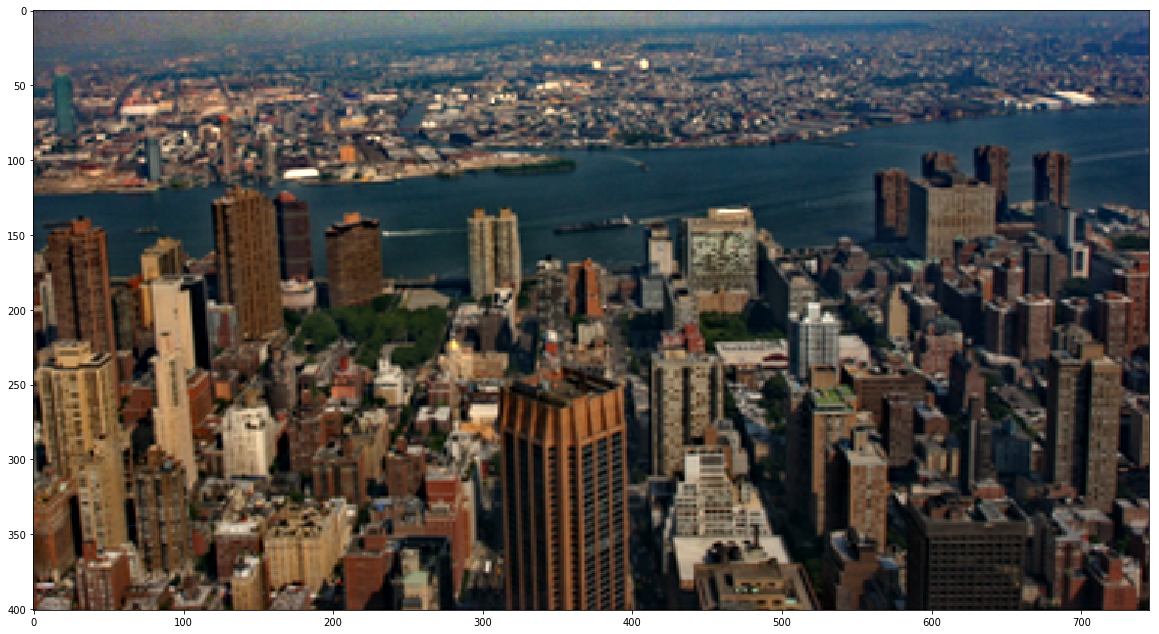

In [4]:
dehazer = DarkPriorChannelDehaze()
img_dehaze = dehazer(image)
img_dehaze[img_dehaze > 255] = 255
img_dehaze[img_dehaze < 0] = 0
plt.imshow(img_dehaze.astype('uint8'))

# Write Image

In [5]:
io.imsave('./data/output4.bmp', img_dehaze.astype('uint8'))

# Show Dark Channel

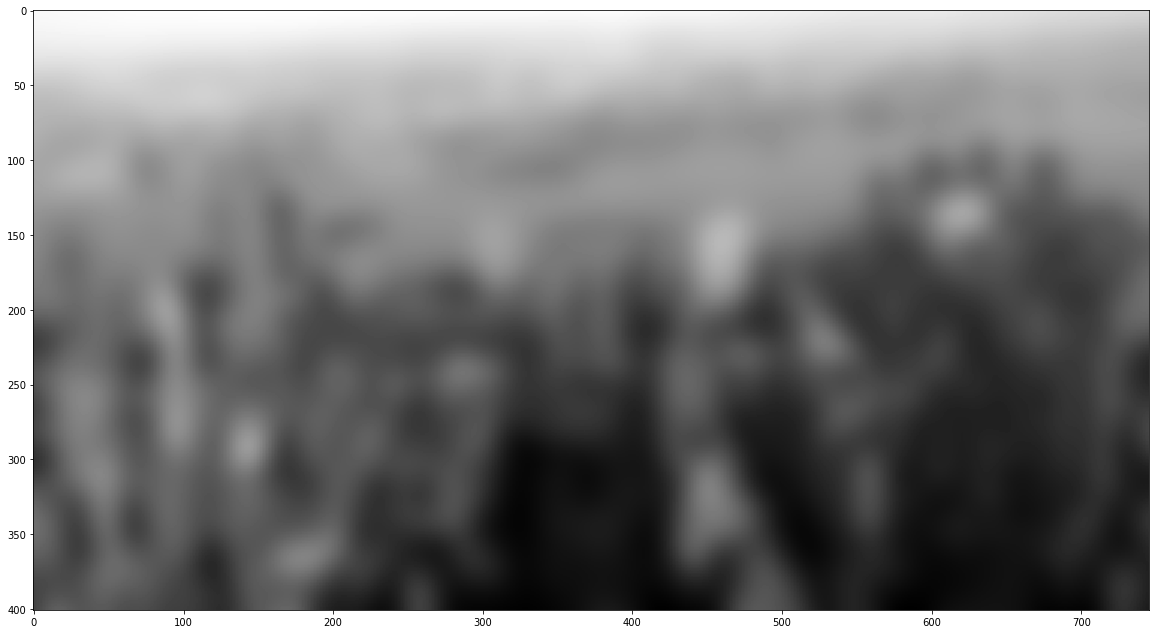

In [6]:
plt.imshow(dehazer.dark_channel(image).reshape((401, -1)), cmap='gray')

# Show Transmission Channel

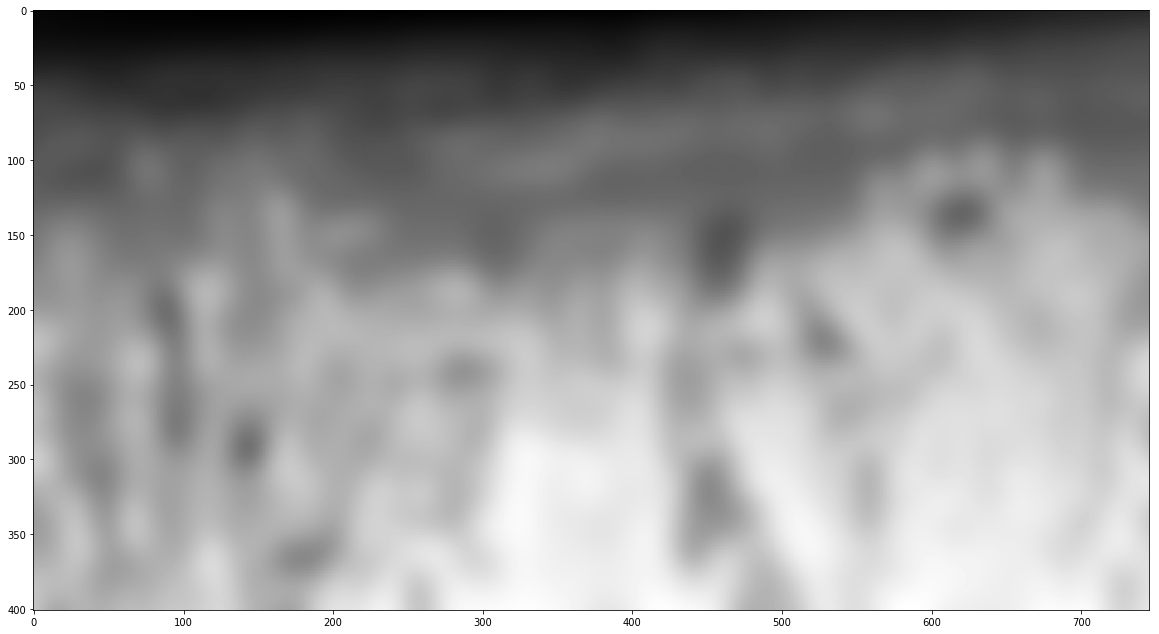

In [8]:
img_dark = dehazer.dark_channel(image)
# img_dark_2 = dehazer.gaussian_filter(img_dark)
at = dehazer.atmosphere(image, img_dark)
t = dehazer.transmission(image, at, img_dark)

plt.imshow(t.reshape((401, -1)), cmap='gray')